In [1]:
import gzip
import json
import os
import shutil

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa

from basenji import dna_io

In [2]:
np.random.seed(44)

## Precursors

In [3]:
gtf_file = '/home/drk/common/data/genomes/hg38/genes/gencode36/gencode.v36.basic.annotation.gtf.gz'
utr3_fasta = '/home/drk/rnaml/analysis/1-27/V36.3UTRs.selectedTranscript.fa'
utr5_fasta = '/home/drk/rnaml/analysis/1-27/V36.5UTRs.selectedTranscript.fa'
orf_fasta = '/home/drk/rnaml/analysis/1-27/V36.ORFs.selectedTranscript.fa'

stability_file = '/home/vagar/RNAbinding/transcript_isoform_analysis/Rinn_avg_K562.txt'
features_file = '/home/vagar/RNAbinding/half_life/human/half_life_features.txt'

In [4]:
def gtf_kv(s):
    """Convert the last gtf section of key/value pairs into a dict."""
    d = {}

    a = s.split(';')
    for key_val in a:
        if key_val.strip():
            eq_i = key_val.find('=')
            if eq_i != -1 and key_val[eq_i-1] != '"':
                kvs = key_val.split('=')
            else:
                kvs = key_val.split()

            key = kvs[0]
            if kvs[1][0] == '"' and kvs[-1][-1] == '"':
                val = (' '.join(kvs[1:]))[1:-1].strip()
            else:
                val = (' '.join(kvs[1:])).strip()

            d[key] = val

    return d

In [5]:
def trim_dot(gene_id):
    """Trim the .xyz suffix from a GENCODE gene_id."""
    dot_i = gene_id.find('.')
    if dot_i != -1:
        gene_id = gene_id[:dot_i]
    return gene_id

In [6]:
def read_gene_fasta(fasta_file, trim_geneid=False):
    """Read gene sequences from FASTA into a dict."""
    if fasta_file[-3:] == '.gz':
        fasta_open = gzip.open(fasta_file, 'rt')
    else:
        fasta_open = open(fasta_file, 'r')
        
    gene_seq = {}
    for line in fasta_open:
        if line[0] == '>':
            gene = line[1:].rstrip()
            if trim_geneid:
                gene = trim_dot(gene)
            gene_seq[gene] = ''
        else:
            gene_seq[gene] += line.rstrip()
            
    fasta_open.close()
        
    return gene_seq

## Read stability measurements

In [7]:
# read sample table
stability_df = pd.read_csv(stability_file, sep='\t', names=['Gene','Stability'])

In [9]:
# additional gene attributes

gene_type = {}
gene_name = {}
for line in gzip.open(gtf_file, 'rt'):
    a = line.split('\t')
    if len(a) > 8 and a[2] == 'gene':
        kv = gtf_kv(a[8])
        gene_id = trim_dot(kv['gene_id'])
        gene_type[gene_id] = kv['gene_type']
        gene_name[gene_id] = kv['gene_name']
    
stability_type = []
stability_name = []
for gene_id in stability_df.Gene:
    if gene_id in gene_type:
        stability_type.append(gene_type[gene_id])
        stability_name.append(gene_name[gene_id])
    else:
        stability_type.append('depracated')
        stability_name.append('NA')
    
stability_df['Name'] = stability_name
stability_df['Type'] = stability_type
stability_df = stability_df[['Gene','Name','Type','Stability']]
stability_df.head()

,Gene,Name,Type,Stability
0,ENSG00000000419,DPM1,protein_coding,11.198840
1,ENSG00000000457,SCYL3,protein_coding,1.878456
2,ENSG00000000460,C1orf112,protein_coding,4.654573
3,ENSG00000000971,CFH,protein_coding,14.485273
4,ENSG00000001036,FUCA2,protein_coding,10.422527


In [10]:
# count gene types
stability_df.value_counts('Type')

Type
protein_coding                        10500
lncRNA                                  361
depracated                              232
transcribed_unprocessed_pseudogene       28
transcribed_unitary_pseudogene            8
transcribed_processed_pseudogene          4
unprocessed_pseudogene                    3
processed_pseudogene                      2
dtype: int64

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


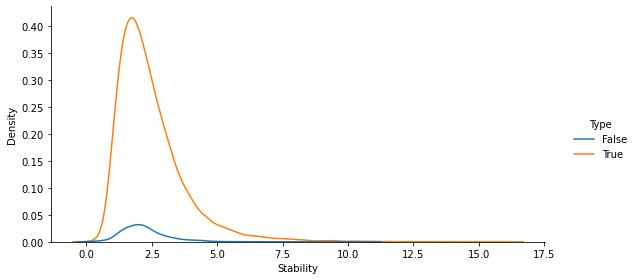

In [11]:
# plot stability for mRNA versus rest
sns.displot(x=np.sqrt(stability_df.Stability),
            hue=(stability_df.Type=='protein_coding'),
            kind='kde', aspect=2, height=4)

In [12]:
# keep only mRNAs
stability_df = stability_df[stability_df.Type=='protein_coding']
del stability_df['Type']

## Read UTRs

In [13]:
gene_utr3 = read_gene_fasta(utr3_fasta)
print(len(gene_utr3))

gene_utr5 = read_gene_fasta(utr5_fasta)
print(len(gene_utr5))

gene_orf = read_gene_fasta(orf_fasta)
print(len(gene_orf))

10628
10539
10499


In [14]:
# construct gene table, with stability and transcript segment lengths

stability_utr3 = []
stability_utr5 = []
stability_orf = []

gene_seq = {}

for gene in stability_df.Gene:
    if gene in gene_utr5:
        gene_seq[gene] = gene_utr5[gene]
        stability_utr5.append(len(gene_utr5[gene]))
    else:
        stability_utr5.append(0)
    if gene in gene_orf:
        gene_seq[gene] = gene_seq.get(gene,'') + gene_orf[gene]
        stability_orf.append(len(gene_orf[gene]))
    else:
        stability_orf.append(0)
    if gene in gene_utr3:
        gene_seq[gene] = gene_seq.get(gene,'') + gene_utr3[gene]
        stability_utr3.append(len(gene_utr3[gene]))
    else:
        stability_utr3.append(0)
        
stability_df['UTR5'] = stability_utr5
stability_df['ORF'] = stability_orf
stability_df['UTR3'] = stability_utr3
stability_df['Length'] = stability_df['UTR5'] + stability_df['ORF'] + stability_df['UTR3']
stability_df.shape

(10500, 7)

In [15]:
# attach additional features

features_df = pd.read_csv(features_file, sep='\t')
features_df.set_index('ENSID',inplace=True)
features_df.head()

,EXPRESSION,UTR5LEN,CDSLEN,INTRONLEN,UTR3LEN,UTR5GC,CDSGC,UTR3GC,ORFEXONDENSITY
ENSID,,,,,,,,,
ENSG00000000003,13.7465,111,728,5943,1354,0.625,0.412,0.368,9.62
ENSG00000000005,0.0120,216,944,13756,167,0.470,0.419,0.393,7.42
ENSG00000000419,42.1780,31,851,22542,264,0.000,0.435,0.262,11.75
ENSG00000000457,4.0455,220,2213,37814,638,0.613,0.450,0.369,5.87
ENSG00000000460,3.2680,697,2537,54345,1092,0.411,0.421,0.355,8.67
...,...,...,...,...,...,...,...,...,...
ENSG00000259399,75.4210,115,461,36923,332,0.658,0.509,0.450,8.68
ENSG00000259431,8.1710,735,688,1396,1430,0.620,0.586,0.545,2.91
ENSG00000259511,0.6085,11,390,9253,89,0.583,0.492,0.256,7.69


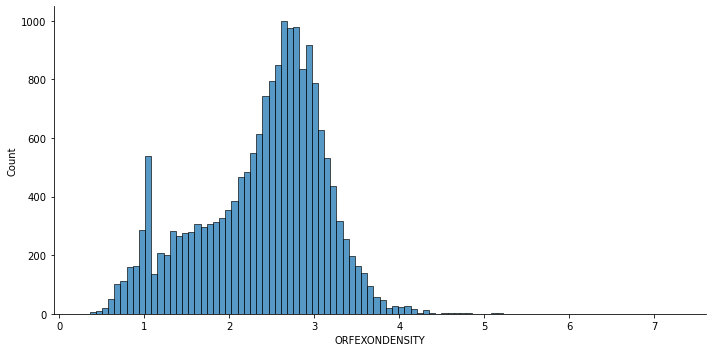

In [16]:
# plot exon distributions
sns.displot(np.sqrt(features_df.ORFEXONDENSITY), aspect=2)

In [17]:
# choose threshold
(np.sqrt(features_df.ORFEXONDENSITY) < 4.5).mean()

0.9988051919839244

In [18]:
# clip and attach features

stability_exons = []

for gene in stability_df.Gene:
    if gene in features_df.index:
        stability_exons.append(features_df.loc[gene].ORFEXONDENSITY)
    else:
        stability_exons.append(np.nan)

stability_df['Exons'] = np.clip(np.sqrt(stability_exons), 0, 4.5)

In [19]:
# check
stability_df.loc[np.isnan(stability_df.Exons)].head()

,Gene,Name,Stability,UTR5,ORF,UTR3,Length,Exons
27,ENSG00000004142,POLDIP2,11.613667,79,1107,1484,2670,NaN
347,ENSG00000037241,RPL26L1,9.188656,54,438,230,722,NaN
423,ENSG00000048544,MRPS10,9.618155,12,606,1482,2100,NaN
497,ENSG00000055950,MRPL43,5.005810,72,480,458,1010,NaN
553,ENSG00000061794,MRPS35,5.252778,12,972,845,1829,NaN


In [20]:
# set NaNs to 0
stability_df.Exons.fillna(np.nanmean(stability_df.Exons), inplace=True)

## QC

In [21]:
# check for zero length ORF genes
stability_df[stability_df.ORF==0]

,Gene,Name,Stability,UTR5,ORF,UTR3,Length,Exons
10774,ENSG00000255072,PIGY,7.087454,0,0,0,0,2.172556


PIGY/PYURF seems to be a case of two separate genes that should be considered isoforms of the same gene.

In [22]:
# remove zero length ORF genes
stability_df = stability_df[stability_df.ORF>0]

In [23]:
# check for zero length 3' UTR genes
print(stability_df[stability_df.UTR3==0].shape)
stability_df[stability_df.UTR3==0].sort_values('Stability', ascending=False).head(8)

(70, 8)


,Gene,Name,Stability,UTR5,ORF,UTR3,Length,Exons
7569,ENSG00000168255,POLR2J3,17.822540,132,823,0,955,2.929164
11008,ENSG00000267740,AC024592.3,15.790490,0,506,0,506,2.496809
10272,ENSG00000214954,LRRC69,14.435017,0,1044,0,1044,2.651415
2983,ENSG00000115919,KYNU,13.554290,178,1398,0,1576,3.067572
3644,ENSG00000124657,OR2B6,13.268352,0,942,0,942,1.034408
2770,ENSG00000113396,SLC27A6,11.879809,434,1860,0,2294,2.325941
3010,ENSG00000116161,CACYBP,10.787287,0,243,0,243,2.974895
733,ENSG00000069431,ABCC9,10.746140,0,4650,0,4650,2.870540


In [24]:
# check for zero length 5' UTR genes
print(stability_df[stability_df.UTR5==0].shape)
stability_df[stability_df.UTR5==0].sort_values('Stability', ascending=False).head(8)

(167, 8)


,Gene,Name,Stability,UTR5,ORF,UTR3,Length,Exons
8947,ENSG00000183688,RFLNB,30.536655,0,435,3186,3621,2.156386
8715,ENSG00000180815,MAP3K15,25.957153,0,3942,70,4012,2.884441
10473,ENSG00000233822,H2BC15,18.594810,0,381,51,432,2.461707
6650,ENSG00000161939,RNASEK-C17orf49,17.777900,0,701,199,900,3.182766
1436,ENSG00000099904,ZDHHC8,16.497940,0,2022,1050,3072,2.195450
11008,ENSG00000267740,AC024592.3,15.790490,0,506,0,506,2.496809
10939,ENSG00000261884,AC040162.1,15.440990,0,233,340,573,2.496809
10272,ENSG00000214954,LRRC69,14.435017,0,1044,0,1044,2.651415


## Choose length thresholds

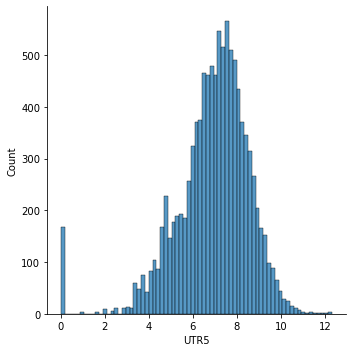

In [25]:
# plot 5'UTR distribution
sns.displot(np.log2(1+stability_df.UTR5))

In [26]:
# choose threshold
utr5_len_t = 2**11
utr5_len_t, (stability_df.UTR5<utr5_len_t).mean()

(2048, 0.9986665396704448)

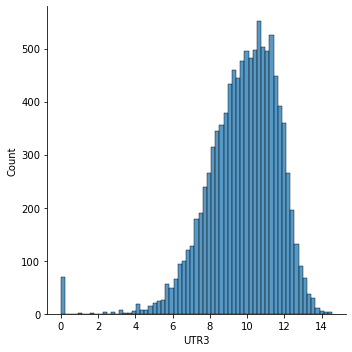

In [27]:
# plot 3'UTR distribution
sns.displot(np.log2(1+stability_df.UTR3))

In [28]:
# choose threshold
utr3_len_t = 3*2**12
utr3_len_t, np.log2(utr3_len_t), (stability_df.UTR3<utr3_len_t).mean()

(12288, 13.584962500721156, 0.9970473378416992)

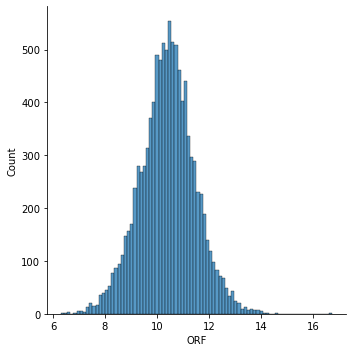

In [29]:
# plot ORF distribution
sns.displot(np.log2(1+stability_df.ORF))

In [30]:
# choose threshold
cds_len_t = 3*2**12
cds_len_t, np.log2(cds_len_t), (stability_df.ORF<cds_len_t).mean()

(12288, 13.584962500721156, 0.9967615963425088)

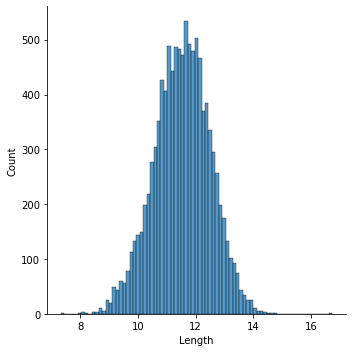

In [31]:
# plot full length distribution
sns.displot(np.log2(1+stability_df.Length))

In [32]:
# choose threshold
full_len_t = 2**14
full_len_t, np.log2(full_len_t), (stability_df.Length<full_len_t).mean()

(16384, 14.0, 0.9969520906753024)

## Training data

In [33]:
# divide into folds

num_folds = 5
num_genes = stability_df.shape[0]
fold_genes = num_genes // num_folds

folds_num = [fold_genes]*(num_folds-1)
fold_final_genes = num_genes - fold_genes*(num_folds-1)
folds_num.append(fold_final_genes)

gene_folds = []
for fi in range(num_folds):
    gene_folds += [fi]*folds_num[fi]
gene_folds = np.array(gene_folds)
np.random.shuffle(gene_folds)

fold_masks = []
for fi in range(num_folds):
    fold_masks.append(gene_folds == fi)

In [34]:
def feature_bytes(values):
    """Convert numpy arrays to bytes features."""
    values = values.flatten().tostring()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[values]))

def tfr_feature_ints(int_list):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=int_list))
def tfr_feature_dna(seq_1hot):
    seq_indexes = np.where(seq_1hot)[1].astype('uint8')
    seq_indexes = seq_indexes.tostring()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[seq_indexes]))
def tfr_feature_targets(targets):
    targets = targets.astype('float16')
    targets = targets.tostring()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[targets]))

In [35]:
def write_fold(fold_index, out_dir, seqs_per_tfr=128, pseudocount=0.125):
    """Write a cross-validation fold's TFRecords."""
    tf_opts = tf.io.TFRecordOptions(compression_type='ZLIB')
    
    # slice fold's genes
    fold_df = stability_df[fold_masks[fold_index]]
    
    gi = 0
    num_tfr = int(np.ceil(fold_df.shape[0] / seqs_per_tfr))
    for fi in range(num_tfr):
        tfr_file = '%s/fold%d-%d.tfr' % (out_dir,fold_index,fi)
        with tf.io.TFRecordWriter(tfr_file, tf_opts) as writer:
            for ti in range(seqs_per_tfr):
                if gi < fold_df.shape[0]:
                    sgene = fold_df.iloc[gi]
                    gene_id = sgene.Gene

                    # utr5
                    if gene_id in gene_utr5:        
                        gene_utr5_1hot = dna_io.dna_1hot(gene_utr5[gene_id])
                        if gene_utr5_1hot.shape[0] > utr5_len_t:
                            gene_utr5_1hot = gene_utr5_1hot[-utr5_len_t:]
                    else:
                        gene_utr5_1hot = np.zeros((0,4), dtype='bool')

                    # cds
                    if gene_id in gene_orf:        
                        gene_cds_1hot = dna_io.dna_1hot(gene_orf[gene_id])
                        if gene_cds_1hot.shape[0] > cds_len_t:
                            li = (gene_cds_1hot.shape[0] - cds_len_t) // 2
                            gene_cds_1hot = gene_cds_1hot[li:li+cds_len_t]
                    else:
                        gene_cds_1hot = np.zeros((0,4), dtype='bool')

                    # utr3
                    if gene_id in gene_utr3:        
                        gene_utr3_1hot = dna_io.dna_1hot(gene_utr3[gene_id])
                        if gene_utr3_1hot.shape[0] > utr3_len_t:
                            li = (gene_utr3_1hot.shape[0] - utr3_len_t)
                            gene_utr3_1hot = gene_utr3_1hot[:utr3_len_t]
                    else:
                        gene_utr3_1hot = np.zeros((0,4), dtype='bool')
                        
                    # features
                    gene_features = np.array([sgene.Exons])

                    # targets
                    targets = np.log2(sgene.Stability + pseudocount)

                    # hash to bytes
                    seq_lengths = [gene_utr5_1hot.shape[0], gene_cds_1hot.shape[0], gene_utr3_1hot.shape[0]]
                    features_dict = {
                        'lengths': tfr_feature_ints(seq_lengths),
                        'utr3': tfr_feature_dna(gene_utr3_1hot),
                        'cds': tfr_feature_dna(gene_cds_1hot),
                        'utr5': tfr_feature_dna(gene_utr5_1hot),
                        'features': tfr_feature_targets(gene_features),
                        'targets': tfr_feature_targets(targets)
                    }

                    # write example
                    example = tf.train.Example(features=tf.train.Features(feature=features_dict))
                    writer.write(example.SerializeToString())
                
                    # next gene
                    gi += 1

In [36]:
################################################################
# output directory

out_dir = 'data_cv'
if os.path.isdir(out_dir):
    shutil.rmtree(out_dir)
os.mkdir(out_dir)

################################################################
# stats
stats_dict = {}
stats_dict['num_targets'] = 1
stats_dict['target_length'] = 1
stats_dict['num_features'] = 1

stats_dict['length_utr5'] = utr5_len_t
stats_dict['length_cds'] = cds_len_t
stats_dict['length_utr3'] = utr3_len_t
stats_dict['length_full'] = full_len_t

stats_dict['num_folds'] = num_folds
for fi in range(num_folds):
    stats_dict['fold%d_seqs' % fi] = folds_num[fi]

with open('%s/statistics.json' % out_dir, 'w') as stats_json_out:
    json.dump(stats_dict, stats_json_out, indent=4)

################################################################
# write tfrecords

tfrecords_dir = '%s/tfrecords' % out_dir
os.mkdir(tfrecords_dir)
for fi in range(num_folds):
    write_fold(fi, tfrecords_dir)

<ipython-input-34-13d201adb886>:10: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  seq_indexes = seq_indexes.tostring()
<ipython-input-34-13d201adb886>:14: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  targets = targets.tostring()
